In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [2]:
Sigmin = torch.FloatTensor([0.01,0.01])

In [3]:
def conditional_field(position, time, target, sigmin):
    return (target - (1-sigmin)*position) / (1-(1-sigmin)*time)

def conditional_sample(target, time, sigmin, noise):
    mean = target*time
    sigma = 1 - (1-sigmin)*time
    return mean + sigma*noise

In [4]:
import sklearn.datasets as skld
def sample_data(N = 100):
    # target = torch.FloatTensor(np.random.choice([2,-2], size = batch_size, replace=True))
    target = torch.FloatTensor(skld.make_moons(N)[0])
    return target


def train():
    model = torch.nn.Sequential(
        torch.nn.Linear(3,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,2)
    )
    opt = torch.optim.Adam(model.parameters(), 1e-3)

    for i in range(20000):
        batch_size = 1000
        target = sample_data(batch_size)
        times = torch.rand((batch_size,1))
        position = conditional_sample(target, times, Sigmin, torch.randn((batch_size,2)))
        xt = torch.cat([position, times.reshape(-1,1)],dim=-1)
        mfield = model(torch.FloatTensor(xt))
        cond_field = torch.FloatTensor(conditional_field(xt[:,:-1].numpy(),xt[:,-1:].numpy(), target.numpy(), Sigmin.numpy().reshape(1,-1)))
        loss = torch.nn.functional.mse_loss(mfield, cond_field)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 1000 == 0:
            print(i,float(loss))
    return model
trained_model = train()

/Users/lukasheinrich/.pyenv/versions/3.11.4/envs/llama/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


0 1.7063920497894287
1000 0.9728812575340271
2000 0.9075480103492737
3000 0.8940340280532837
4000 0.9076343774795532
5000 0.91176438331604
6000 0.8694308996200562
7000 0.961311399936676
8000 0.9173674583435059
9000 0.9692350625991821
10000 0.885056734085083
11000 0.9122652411460876
12000 0.9222955107688904
13000 0.905821681022644
14000 0.9481986165046692
15000 0.931122362613678
16000 0.8848775625228882
17000 0.9264364242553711
18000 0.9118135571479797
19000 0.9244229793548584


In [17]:
tint = torch.FloatTensor(np.linspace(0,1,31))
noise = torch.randn(1000,2)
with torch.no_grad():
    xint = odeint(
        lambda t,x: trained_model(torch.cat([x,torch.full((len(x),1), t.item())],dim=-1)),
        noise,
        torch.tensor(tint)
    )

/var/folders/hn/y10jq2sn3cs3wnqv65l2rc040000gn/T/ipykernel_7767/2273706512.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(tint)


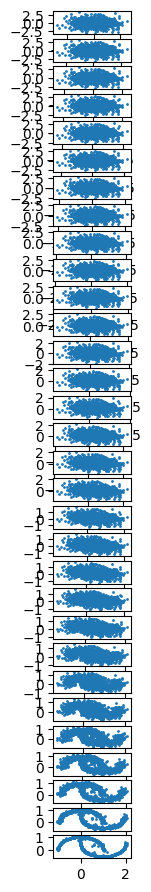

In [18]:
f, axarr = plt.subplots(31,1)
for idx, ax in enumerate(axarr.ravel()):
    ax.scatter(xint[idx][:,0],xint[idx][:,1], s = 1)
f.set_size_inches(1,11)

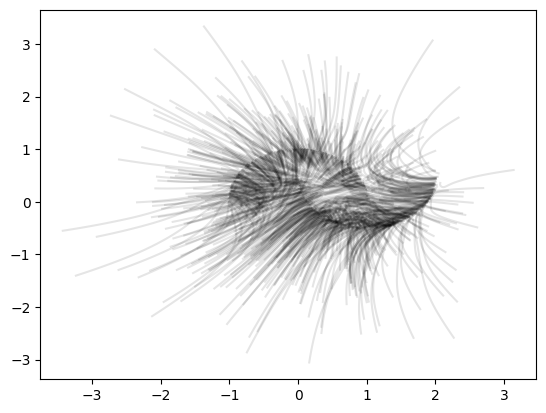

In [19]:
plt.plot(xint[:,:,0],xint[:,:,1],c = 'k', alpha = 0.1);